In [1]:
import numpy as np
from source.Files_operating import read_sht_data

shtRipper v1.3


In [2]:
import time
import copy
import random

from matplotlib.colors import CSS4_COLORS as COLORS

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

colors = ['gold', 'brown', 'black', 'seagreen', 'skyblue', 'cyan', 'yellow', 'violet', 'royalblue', 'sandybrown', 'grey', 'gray', 'indigo', 'rosybrown', 'darkviolet', 'coral', 'pink', 'magenta', 'red', 'springgreen', 'darkblue', 'silver', 'seashell', 'green', 'navy', 'purple', 'sienna', 'chocolate', 'orange', 'blue']

In [4]:
def get_boarders(data: np.array, loc_max_ind=None, scale=1.5):
    loc_max_ind = np.argmax(data)
    dist_ind = np.argsort(np.abs(data - data[loc_max_ind] / scale))
    return Slice(dist_ind[dist_ind <= loc_max_ind][0], dist_ind[dist_ind >= loc_max_ind][0])


class Slice:
    def __init__(self, start_index=0, end_index=0):
        self.l = start_index
        self.r = end_index
        self.mark = 1.0

    def set_boarders(self, start_index: int, end_index: int) -> None:
        self.l = start_index
        self.r = end_index

    def set_mark(self, mark: int) -> None:
        self.mark = mark

    def copy(self):
        new_slice = Slice(self.l, self.r)
        new_slice.set_mark(new_slice.mark)
        return new_slice

    def check_length(self, len_edge: int) -> bool:
        return self.r - self.l > len_edge

    def check_dist(self, other, dist_edge: int) -> bool:
        return other.l - self.r > dist_edge

    def collide_slices(self, other, dist_edge: int) -> bool:
        if not self.check_dist(other, dist_edge):
            self.r = other.r
            return True
        return False

    def step(self) -> None:
        self.r += 1

    def move(self, delta: int) -> None:
        self.r += delta
        self.l += delta

    def expand(self, delta: int) -> None:
        self.r += delta
        self.l -= delta

    def collapse_boarders(self) -> None:
        self.l = self.r

    def is_null(self) -> bool:
        return self.l == self.r

    def to_list(self):
        return [self.l, self.r]

    def __repr__(self):
        return f"({self.l}, {self.r})"


class Signal_meta:
    def __init__(self, chanel_name="da", processing_flag=False, 
                 quantile_edge=0.0, std_edge=1.0, 
                 length_edge=10, distance_edge=10, scale=1.5, step_out=10, 
                 std_bottom_edge=0, std_top_edge=1, d_std_bottom_edge=3, d_std_top_edge=6, amplitude_ratio=0.5):
        self.name = chanel_name
        self.proc_fl = processing_flag
        
        self.len_edge = length_edge
        self.dist_edge = distance_edge
        self.scale = scale
        self.step_out = step_out
        
        self.q = quantile_edge
        self.std = std_edge
        
        self.d_q = quantile_edge
        self.d_std = std_edge

        self.std_top = std_top_edge
        self.std_bottom = std_bottom_edge
        self.d_std_top = d_std_top_edge
        self.d_std_bottom = d_std_bottom_edge

        self.max_min_ratio = amplitude_ratio
        
    def set_statistics(self, data: np.array, data_diff: np.array, percentile: float, d_percentile: float, std_bottom_edge=0, std_top_edge=1, d_std_bottom_edge=3, d_std_top_edge=6, amplitude_ratio=0.5):
        self.q = np.quantile(data, percentile)
        self.std = data.std()
        self.std_top = std_top_edge
        self.std_bottom = std_bottom_edge
        
        self.d_q = np.quantile(data_diff, percentile)
        self.d_std = data_diff.std()
        if self.name == "sxr":
            a = 10.5
            b = -850
            self.d_std_top = d_std_top_edge / d_std_bottom_edge * a * np.exp(b * self.d_std)
            self.d_std_bottom = a * np.exp(b * self.d_std)
        else:
            self.d_std_top = d_std_top_edge
            self.d_std_bottom = d_std_bottom_edge            

        self.max_min_ratio = amplitude_ratio

    def set_edges(self, length_edge=10, distance_edge=10, scale=1.5, step_out=10):
        self.len_edge = length_edge
        self.dist_edge = distance_edge
        self.scale = scale
        self.step_out = step_out


def get_peaks(data: np.array, s_i: int) -> np.array:
    peaks_ind = []
    loc_max = data.min()
    m_v = data.mean()
    loc_max_ind = 0
    increase_fl = False
    for i in range(data.shape[0] - 1):
        if loc_max < data[i]:
            increase_fl = True
            loc_max = data[i]
            loc_max_ind = i
        elif abs((loc_max - data[i]) / (loc_max + 1e-10)) > 0.5 and increase_fl:
            if abs(loc_max) > 5 * abs(m_v + 1e-10):
                peaks_ind.append(loc_max_ind)
            # print(s_i + loc_max_ind, abs((loc_max - data[i]) / loc_max), abs((loc_max - m_v) / m_v))  # len(peaks_ind),
            increase_fl = False

        if not increase_fl or data[i] < data[i + 1]:
            loc_max = data[i]
            loc_max_ind = i
    return np.array(peaks_ind)

def get_boarders_d2(data:np.array, diff_data: np.array, s_i: int, scale=1.5):
    d2_data = np.diff(diff_data)
    peaks_ind = get_peaks(d2_data, s_i)

    if len(peaks_ind) == 0:
        return Slice(0, diff_data.shape[0])
    if len(peaks_ind) == 1:
        scale_slice = get_boarders(data, scale=scale)
        # print(scale_slice)
        if peaks_ind[0] < diff_data.shape[0] - peaks_ind[0]:
            if peaks_ind[0] - scale_slice.r < 0:
                return Slice(peaks_ind[0], scale_slice.r)
            else:
                return Slice(peaks_ind[0], diff_data.shape[0])
        else:
            if peaks_ind[0] - scale_slice.l > 0:
                return Slice(scale_slice.l, peaks_ind[0])
            else:
                return Slice(0, peaks_ind[0])
    return Slice(peaks_ind[0], peaks_ind[-1])

def proc_boarders(data: np.array, data_diff: np.array, start_ind: int, scale=1.5) -> Slice:
    step = 5
    
    diff_coeff = 1
    if data_diff[start_ind] < 0:
        diff_coeff = -1
    
    cur_ind = (start_ind + diff_coeff * step) if 0 < start_ind + diff_coeff * step < data.shape[0] else start_ind
    while 0 < cur_ind + diff_coeff * step < data.shape[0] and data_diff[cur_ind] * data_diff[cur_ind + diff_coeff * step] > 0:
        cur_ind += diff_coeff * step

    # print(cur_ind - 3 * step, cur_ind + 3 * step, end=" ")
    max_ind = np.argmax(data[max(cur_ind - 3 * step, 0): min(cur_ind + 3 * step, data.shape[0])]) + cur_ind - step
    length = max(abs(max_ind - start_ind), 3 * step)
    # print(max_ind, length)

    # print(max_ind - length, max_ind + 2 * length, end=" ")
    res_slice = get_boarders_d2(data[max(max_ind - length, 0): min(max_ind + 2 * length, data.shape[0])], data_diff[max(max_ind - length, 0): min(max_ind + 2 * length, data.shape[0])], max(max_ind - length, 0), scale=scale)  # get_boarders(data[max_ind - length: max_ind + 2 * length], loc_max_ind=length) | Slice(0, 3 * length)
    res_slice.move(max_ind - length)
    # print(res_slice.l, res_slice.r)

    # add checking diff on right & left boarder (cut on D2 peaks) - done
    # add dtw classification (None | ELM | LSO)

    # print(res_slice.l, res_slice.r, end=" ")
    # print(abs(data_diff[res_slice.l:res_slice.r].max() - np.quantile(data_diff, 0.7)), data_diff.std())
    
    return res_slice


def proc_slices(mark_data: np.array, data: np.array, data_diff: np.array, meta: Signal_meta) -> np.array:  # data: np.array, , scale=1.5 , step_out=10
    proc_slice = Slice(0, 50)
    cur_slice = Slice(0, 51)
    f_fragment = False

    res_mark = np.copy(mark_data)
    res_mark[cur_slice.l: cur_slice.r] = 0.0
    cur_slice.collapse_boarders()
    proc_slice = cur_slice.copy()

    c = 0
    
    while cur_slice.r < res_mark.shape[0]:
        if res_mark[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            # print(start_ind, end_ind)
            if not cur_slice.check_length(meta.len_edge):
                res_mark[cur_slice.l: cur_slice.r] = 0.0
            elif not proc_slice.collide_slices(cur_slice, meta.dist_edge):
                if meta.proc_fl and meta.scale > 1:
                    res_mark[proc_slice.l: proc_slice.r] = 0.0
                    start_ind = proc_slice.l if data_diff[proc_slice.l] > 0 else proc_slice.r
                    proc_slice = proc_boarders(data, data_diff, start_ind, meta.scale)
                    
                    cur_slice = Slice(proc_slice.r, proc_slice.r)
                
                proc_slice.expand(meta.step_out)

                if meta.proc_fl and abs(data_diff[proc_slice.l:proc_slice.r].max() - meta.d_q) < meta.d_std_top * meta.d_std and \
                   abs(data_diff[proc_slice.l:proc_slice.r].min() - meta.d_q) < meta.d_std_top * meta.d_std:
                    proc_slice.set_mark(0)
                
                if meta.name == "sxr":
                    if abs(abs(data_diff[proc_slice.l:proc_slice.r].min()) - meta.d_q) > meta.d_std_top * meta.d_std:
                        proc_slice.set_mark(1)
                        
                    if abs(data_diff[proc_slice.l:proc_slice.r].max() / data_diff[proc_slice.l:proc_slice.r].min()) < meta.max_min_ratio:
                        proc_slice.set_mark(1)
                    else:
                        proc_slice.set_mark(0)
                
                res_mark[proc_slice.l: proc_slice.r] = proc_slice.mark
                c += proc_slice.mark
                
                proc_slice = cur_slice.copy()
            f_fragment = False
            cur_slice.collapse_boarders()
        elif not f_fragment:
            cur_slice.collapse_boarders()
            if proc_slice.is_null():
                proc_slice = cur_slice.copy()
    
        cur_slice.step()
    # print(c)

    return res_mark


def get_slices(mark_data: np.array):
    cur_slice = Slice(0, 1)
    f_fragment = False

    slices_list = []
    
    while cur_slice.r < mark_data.shape[0]:
        if mark_data[cur_slice.r] == 1.0:
            if not f_fragment:
                f_fragment = True
        elif f_fragment:
            slices_list.append(copy.copy(cur_slice))
            f_fragment = False
            cur_slice.collapse_boarders()
        elif not f_fragment:
            cur_slice.collapse_boarders()
        cur_slice.step()

    return slices_list


def get_d2_peaks(diff_data: np.array, mark_data: np.array, s_i: int):
    l_ = 0
    fr_fl = False
    peaks_ind = []
    for i in range(mark_data.shape[0]):
        if mark_data[i] == 1 and not fr_fl:
            fr_fl = True
            l_ = i
        elif fr_fl and mark_data[i] == 0:
            fr_fl = False
            d2_data = np.diff(diff_data)
            res = get_peaks(d2_data[l_-10:i+30], s_i) + l_-10
            peaks_ind += res.tolist()
    peaks_ind = np.array(peaks_ind)
    return peaks_ind, d2_data[peaks_ind]


def zero_bin_search(arr: np.array):
    l = 0
    r = arr.shape[0] - 1
    if arr[l] * arr[r] > 0 or r - l <= 0:
        return -1
    
    while r - l > 1:
        m = (r - l) // 2 + l
        if arr[l] * arr[m] <= 0:
            r = m
        else:
            l = m
    
    return r if arr[l] > arr[r] else l


def get_d1_crosses(d1_data: np.array, d2_data: np.array, start: int, end: int, d1_coef=1) -> np.array:
    d1_std = d1_data.std()
    d1_m = d1_data.mean()
    d2_std = d2_data.std()
    d2_m = d2_data.mean()
    
    cur_slice = Slice(start, start + 1)
    f_slice = False
    ans = []
    while cur_slice.r < end + 1:
        if abs(d1_data[cur_slice.r] - d1_m) < d1_std * d1_coef and d2_data[cur_slice.r] - d2_m < d2_std / 3 * 2:
            if not f_slice and (d1_data[cur_slice.r - 1] - d1_m) > d1_std * d1_coef:
                f_slice = True
        
        elif f_slice:  #  and d1_data[cur_slice.r] < 0
            # print(cur_slice)
            if d1_data[cur_slice.r] > d1_m:
                cur_slice.r = np.argmin(d1_data[cur_slice.l: cur_slice.r]) + cur_slice.l
                
            if d1_data[cur_slice.l] >= d1_m and d1_data[cur_slice.r] <= d1_m:
                # print(cur_slice)
                zero_i = zero_bin_search(d1_data[cur_slice.l: cur_slice.r])
                if zero_i != -1:
                    ans.append(zero_i + cur_slice.l)
            
            f_slice = False
            cur_slice.collapse_boarders()
            
        elif not f_slice:
            cur_slice.collapse_boarders()
    
        cur_slice.step()

    if f_slice:
        if d1_data[cur_slice.r] > d1_m:
            cur_slice.r = np.argmin(d1_data[cur_slice.l: cur_slice.r]) + cur_slice.l
            
        if d1_data[cur_slice.l] >= d1_m and d1_data[cur_slice.r] <= d1_m:
            zero_i = zero_bin_search(d1_data[cur_slice.l: cur_slice.r])
            if zero_i != -1:
                ans.append(zero_i + cur_slice.l)
    return np.array(ans)

In [5]:
def combine_groups(groups):
    groups.sort(key=lambda x: len(x), reverse=True)
    d_groups = {}
    for i in range(len(groups)):
        d_groups[i] = True
    res_groups = []
    i = 0
    while i < len(groups):
        j = 0
        while j < len(groups):  # for every group we check all next groups about subsequention
            if i == j:
                j += 1
                continue
            arr1 = groups[i]
            arr2 = groups[j]
            if arr1[0] >= arr2[0]:  # check that arrays are consistent
                j += 1
                continue
            k = check_subsequention(arr1, arr2)  # get len of subsequention
            if k != -1 and k != len(arr2):  # check valide & not full subsequention
                d_groups[i] = False
                d_groups[j] = False
                res_arr = arr1 + arr2[k:]
                if not array_equasion(groups[-1], res_arr):
                    groups.append(res_arr)
                    res_groups.append(res_arr)
            j += 1
        i += 1

    for i in range(len(groups)):
        if d_groups[i]:
            res_groups.append(groups[i])
    return res_groups


def check_subsequention(arr1, arr2) -> int:    
    n = min(len(arr1), len(arr2))
    # print(arr1, arr2, n)
    for i in range(1, n + 1):
        # print(i, arr1[-i:], arr2[:i])
        if arr1[-i] < arr2[0]:
            return -1
        if array_equasion(arr1[-i:], arr2[:i]):
            return i
    return -1


def array_equasion(arr1, arr2) -> bool:
    if len(arr1) != len(arr2):
        return False
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            return False
    return True


def in_array(arr1, arr2) -> bool:
    if len(arr1) > len(arr2):
        return False
    for i in range(len(arr2) - len(arr1) + 1):
        if array_equasion(arr1, arr2[i:i + len(arr1)]):
            return True
    return False


def get_valide_groups_from_struct_by_delta(groups_struct, delta, DELTA_DELTA, MIN_GROUP, DELTA_MAX):  # groups_struct = {Point: {Delta: [mistake: float, group: list]}}
    res_groups = []
    if delta < DELTA_MAX:
        # get groups from delta
        for item in groups_struct[delta]:
            if len(item[1]) > MIN_GROUP:
                res_groups.append(item[1])
                
        # get groups from delta +- delta_delta 
        for d2 in groups_struct.keys():
            if d != d2 and d2 < DELTA_MAX and abs(d - d2) / d <= DELTA_DELTA:
                for item in groups_struct[d2]:
                    if len(item[1]) > MIN_GROUP:
                        res_groups.append(item[1])
    return res_groups


def get_valide_groups_from_struct_by_amplitude(groups_struct, d_alpha, peaks):
    res_groups = []
    g_set = set()
    for delta in groups_struct.keys():
        for item in groups_struct[delta]:
            p_arr = item[1]
            n = len(p_arr)
            cur_group = [p_arr[0]]
            group_m_amplitude = d_alpha[peaks[cur_group]][0]
            
            if n <= 2 and p_arr[1] != p_arr[0] + 1:  # check valid by consistance on 0 elemnt
                continue
            
            for i in range(1, n):
                if i < n - 1 and p_arr[i + 1] != p_arr[i] + 1:  # check valid by consistance on i elemnt
                    if abs(d_alpha[peaks[p_arr[i]]] - group_m_amplitude) / max(group_m_amplitude, d_alpha[peaks[p_arr[i]]]) <= 0.34:
                        cur_group.append(p_arr[i])
                        group_m_amplitude = np.nanmean(d_alpha[peaks[cur_group]])
                    break
                
                if abs(d_alpha[peaks[p_arr[i]]] - group_m_amplitude) / max(group_m_amplitude, d_alpha[peaks[p_arr[i]]]) <= 0.34:
                    cur_group.append(p_arr[i])
                    group_m_amplitude = np.nanmean(d_alpha[peaks[cur_group]])
                elif d_alpha[peaks[p_arr[i]]] > group_m_amplitude:
                    if len(cur_group) > 1:
                        res_groups.append(cur_group)
                    
                    cur_group = [p_arr[i]]
                    group_m_amplitude = d_alpha[peaks[cur_group]][0]
            if len(cur_group) > 0:
                group_str = "/".join(list(map(str, cur_group)))
                if group_str not in g_set:
                    g_set.add(group_str)
                    res_groups.append(cur_group)
                
    return res_groups


def get_unique_point_from_groups(groups):
    set_p = set()
    for group in groups:
        set_p = set_p.union(set(group))
    return sorted(list(set_p))


def get_groups_2(arr): # -> groups = {Delta: [mistake: float, group: list]}
    n = len(arr)
    res_struct = {}
    if n < 2:
        return res_struct
    cur_delta = arr[1] - arr[0]
    cur_group = [0, 1]
    cur_err = 0.0
    for i in range(2, n):
        err = abs(arr[i] - (arr[cur_group[-1]] + cur_delta)) - int(random.random() * 10)
        if cur_err + err < cur_delta:  # check valide
            cur_err += err
            cur_group.append(i)
        else:  # save cur group & upd pointer
            if cur_delta in res_struct.keys():
                res_struct[cur_delta].append([cur_err, cur_group])
                res_struct[cur_delta].sort(key=lambda x: len(x[1]), reverse=True)
            else:
                res_struct[cur_delta] = [[cur_err, cur_group]]
            
            cur_delta = arr[i] - arr[cur_group[-1]]
            cur_group = [cur_group[-1], i]
            cur_err = 0.0
    
    if cur_delta in res_struct.keys():
        res_struct[cur_delta].append([cur_err, cur_group])
        res_struct[cur_delta].sort(key=lambda x: len(x[1]), reverse=True)
    else:
        res_struct[cur_delta] = [[cur_err, cur_group]]
    return res_struct


def get_groups(arr): # -> groups = {Delta: [mistake: float, group: list]}
    n = len(arr)
    res_struct = {}
    if n < 2:
        return res_struct
    cur_group = []

    stac_p =  list(range(n - 2, -1, -1))
    while len(stac_p) > 0:
        # print(stac_p, cur_group)
        ind = stac_p.pop()
        # print(ind)
        fl_save = False
        if len(cur_group) == 0:
            cur_delta = arr[ind + 1] - arr[ind]
            cur_group = [ind, ind + 1]
            cur_err = 0.0

            if ind < n - 2:
                stac_p.append(ind + 2)
            else:
                fl_save = True
        else:
            while ind < n - 2 and abs(arr[ind] - (arr[cur_group[-1]] + cur_delta)) >= abs(arr[ind + 1] - (arr[cur_group[-1]] + cur_delta)):
                if ind not in stac_p:
                    stac_p.append(ind)
                ind += 1

            err = abs(arr[ind] - (arr[cur_group[-1]] + cur_delta))
            if cur_err + err < cur_delta:  # check valide
                cur_err += err
                cur_group.append(ind)
                if ind < n - 1:
                    stac_p.append(ind + 1)
                else:
                    fl_save = True
            else:  # save cur group & upd pointer
                fl_save = True
                stac_p.append(ind - 1)
    
        if fl_save or ind == n - 1:
            if cur_delta in res_struct.keys():
                res_struct[cur_delta].append([cur_err, cur_group])
                res_struct[cur_delta].sort(key=lambda x: len(x[1]), reverse=True)
            else:
                res_struct[cur_delta] = [[cur_err, cur_group]]
            cur_group = []
        
    return res_struct


def get_time_delta(arr):
    return (arr[-1] - arr[0]) / (len(arr) - 1)


def merge_peaks(points, d_alpha):
    d = get_time_delta(points)
    res = [points[0]]
    for i in range(1, len(points)):
        if (points[i] - res[-1]) / d < 0.7:
            res[-1] = points[i] if d_alpha[points[i]] > d_alpha[points[i - 1]] else points[i - 1]
        else:
            res.append(points[i])
    return res

def get_groups_from_signal(d_alpha, d_alpha_f, d_alpha_d2f, l_edge, r_edge):  # -> groups = [group: list(time points)]
    DELTA_DELTA = 0.1 # 
    DELTA_MAX = 1000 # points
    MIN_GROUP = 2 # min num points in group

    # get peaks on diagnostic (in the one group)
    peaks = np.array(get_d1_crosses(d_alpha_f, d_alpha_d2f, l_edge, r_edge))
    # m_, std_ = np.mean(d_alpha[pre_peaks]), np.std(d_alpha[pre_peaks])
    # peaks_ind = np.argwhere((m_ - d_alpha[pre_peaks]) / std_ < 1).transpose()[0]  # ((m_ - d_alpha[pre_peaks]) / std_ < 1) | ((m_ - d_alpha[pre_peaks]) / std_ > 10)
    # peaks = pre_peaks[peaks_ind]
    # print(peaks_ind)
    # print((m_ - d_alpha[peaks]) / std_)

    # check amplitude

    # # divide peaks to groups
    prev_peaks = []
    cur_peaks = copy.copy(peaks)
    while not array_equasion(prev_peaks, cur_peaks):
        # print("- logg: ", cur_peaks)
        # save peaks time points
        prev_peaks = copy.copy(cur_peaks)
        # get struct of groups = {Delta: [mistake: float, group: list]}
        all_groups_struct = get_groups(cur_peaks)
        # print("- logg: ", all_groups_struct)
        # get list of valid groups by amplitude
        valid_groups = get_valide_groups_from_struct_by_amplitude(all_groups_struct, d_alpha, cur_peaks)
        valid_groups = list(map(lambda x: merge_peaks(x, d_alpha) if len(x) > 1 else x, valid_groups))
        # print("- logg: ", valid_groups)
        # get list of unique peaks indeces
        peaks_ind = get_unique_point_from_groups(valid_groups)
        # get new peaks time points
        cur_peaks = copy.copy(cur_peaks[peaks_ind])
    
    all_groups_struct = get_groups(cur_peaks)
    # print("- logg: ", all_groups_struct)
    valid_groups = get_valide_groups_from_struct_by_amplitude(all_groups_struct, d_alpha, cur_peaks)
    # print("- logg: ", sorted(valid_groups, key=lambda x: x[0]))
    
    # # group post processing: union by delta & get missing
    # res_groups = []
    # for d in sorted(all_groups_struct.keys()):
    #     # get all groups from d & d+-delta_delta
    #     delta_groups = get_valide_groups_from_struct_by_delta(all_groups_struct, d, DELTA_DELTA, MIN_GROUP, DELTA_MAX)
    #     # combine subsequent groups
    #     res_groups += combine_groups(delta_groups)
    valid_groups = list(map(lambda x: merge_peaks(x, d_alpha) if len(x) > 1 else x, valid_groups))
    valid_groups = list(filter(lambda x: len(x) > 1, sorted(valid_groups, key=lambda x: x[0])))
    res_peaks = [cur_peaks[valid_groups[0]]]
    for gr_indeces in valid_groups[1:]:
        d1, d2 = get_time_delta(cur_peaks[gr_indeces]), get_time_delta(res_peaks[-1])
        # print("- logg: ", res_peaks[-1], gr_indeces, abs(d1 - d2) / d1)
        if (0.3 < abs(d1 - d2) / d1 < 0.5 and d1 >= d2) or (0.3 < abs(d1 - d2) / d1 < 1.2 and d1 < d2):
            # print("- logg: ", res_peaks[-1], gr_indeces, abs(d1 - d2) / d1)
            # res_peaks.append(merge_peaks(cur_peaks[gr_indeces], d_alpha))
            res_peaks.append(cur_peaks[gr_indeces])
            continue
        
        k = check_subsequention(res_peaks[-1], cur_peaks[gr_indeces])  # get len of subsequention
        if k != -1 and k != len(cur_peaks[gr_indeces]):  # check valide & not full subsequention
            res_arr = np.concatenate([res_peaks[-1], cur_peaks[gr_indeces][k:]])
            # print("- logg: ", res_peaks[-1], cur_peaks[gr_indeces], res_arr)
            # res_peaks[-1] = copy.copy(merge_peaks(res_arr, d_alpha))
            res_peaks[-1] = copy.copy(merge_peaks(res_arr, d_alpha))
        elif in_array(res_peaks[-1], cur_peaks[gr_indeces]):
            # print("- logg: ", res_peaks[-1], cur_peaks[gr_indeces])
            # res_peaks[-1] = copy.copy(merge_peaks(cur_peaks[gr_indeces], d_alpha))
            res_peaks[-1] = copy.copy(cur_peaks[gr_indeces])
        elif k != len(cur_peaks[gr_indeces]) and not in_array(cur_peaks[gr_indeces], res_peaks[-1]):
            # print("- logg: ", k, gr_indeces)
            # res_peaks.append(merge_peaks(cur_peaks[gr_indeces], d_alpha))
            res_peaks.append(cur_peaks[gr_indeces])
    return res_peaks

In [6]:
F_ID = 44184
proj_path = "D:/Edu/Lab/Projects/Plasma_analysis"
# D:/Edu/Lab/Projects/Plasma_analysis | C:/Users/f.belous/Work/Projects/Plasma_analysis
sht_dir_path = proj_path + "/data/sht/all/"  

df = read_sht_data(f'sht{F_ID}', sht_dir_path)
df = df.rename(columns={"ch1": "d_alpha"})
df["sxr"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="SXR 50 mkm").ch1
df["nl"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="nl 42 cm (1.5мм) 64pi").ch1
# df["mgd4"] = read_sht_data(f'mhed{F_ID}', mgd_dir_path, data_name="МГД4").ch1
# dbs = read_dataFile(f'data/dbs/{F_ID} DBS.dat')
# mgd_data_tor
# mgd_data_vertical
df["mgd_v"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="МГД быстрый зонд верт.").ch1
# mgd_data_radial
df["mgd_r"] = read_sht_data(f'sht{F_ID}', sht_dir_path, data_name="МГД быстрый зонд рад.").ch1

mgd = df.mgd_v.to_numpy() ** 2 + df.mgd_r.to_numpy() ** 2

df.describe()

,t,d_alpha,sxr,nl,mgd_v,mgd_r
count,393216.000000,393216.000000,393216.000000,393216.000000,393216.000000,393216.000000
mean,0.196608,0.281714,0.386184,21.365807,-0.002304,-0.006000
std,0.113512,0.393401,0.503047,8.429814,0.085549,0.096789
min,0.000000,-0.388535,-0.076685,-5.902667,-5.235000,-5.235000
25%,0.098304,0.012781,0.107358,16.061839,-0.005112,-0.010225
50%,0.196607,0.066460,0.109915,20.788676,-0.002556,-0.005112
75%,0.294911,0.575134,0.439658,30.783231,0.002556,-0.002556
max,0.393215,4.818347,2.356772,48.138483,5.232444,5.232444


In [7]:
d_alpha = df.d_alpha.to_numpy()
sxr = df.sxr.to_numpy()

In [8]:
d_alpha_d1 = np.diff(d_alpha)
sxr_d1 = np.diff(sxr)

In [9]:
from scipy import signal
from source.NN_environment import normalise_series
from sklearn.preprocessing import normalize

# def normalise_series(data):
#     max_value, min_value, mean_value = np.max(data), np.min(data), np.mean(data)
#     return (data - mean_value) / abs(max_value - min_value)

def filt_signal(arr, N, W):
    b, a = signal.butter(N, W)
    return signal.filtfilt(b, a, arr)

def smooth_rect(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def smooth_gauss(y, box_pts, sigma=1):
    x = np.arange(box_pts) - box_pts / 2
    box = 1 / sigma / (2 * np.pi) ** 0.5 * np.exp(-x ** 2 / 2 / sigma ** 2)
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def smooth_steklov(y, box_pts, ro=0.1):    
    c = 1 / 0.4439938161681
    x_ro = (np.arange(box_pts) - box_pts / 2) / (box_pts / 2 * ro)
    box = np.zeros(box_pts)
    box[abs(x_ro) < 1] = 1 / (box_pts / 2 * ro) * c * np.exp(1 / (x_ro[abs(x_ro) < 1] ** 2 - 1))
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

d_alpha_f = filt_signal(d_alpha_d1, 5, 0.1)
sxr_f = filt_signal(sxr_d1, 5, 0.05)

In [10]:
dbs_dir_path = proj_path + "/data/dbs/sht/"
dbs_df = read_sht_data(f'Dref{F_ID}', dbs_dir_path, data_name="ch1")
channels = [1, 2, 3, 4]
for i in channels[1:]:
    dbs_df[f"ch{i}"] = read_sht_data(f'Dref{F_ID}', dbs_dir_path, data_name=f"ch{i}").ch1

dbs_df.describe()

,t,ch1,ch2,ch3,ch4
count,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000
mean,0.164000,0.056893,0.150608,0.156078,0.136923
std,0.036951,0.306641,0.692173,0.190068,0.190111
min,0.100000,-1.636719,-4.000000,-1.193359,-1.324219
25%,0.132000,-0.068359,-0.126953,0.074219,0.056641
50%,0.164000,0.060547,0.152344,0.158203,0.136719
75%,0.196000,0.173828,0.423828,0.234375,0.216797
max,0.228000,2.519531,3.998047,1.802734,1.533203


In [11]:
for ind in range(1, len(channels) + 1, 2):
    w = 0.8
    smooth_lenght = 400
    i_data = dbs_df[f"ch{ind}"].to_numpy() # normalise_series() filt_signal( , 5, w)  smooth_steklov( , smooth_lenght, smooth_lenght / 2)
    i_data /= np.linalg.norm(i_data)
    q_data = dbs_df[f"ch{ind + 1}"].to_numpy()
    q_data /= np.linalg.norm(q_data)

    c_data = filt_signal(i_data, 5, w) + filt_signal(q_data, 5, w)*1j

    fi_data = np.angle(c_data)
    # coef = 1
    # for i in range(1, fi_data.shape[0]):
    #     if q_data[i] * q_data[i - 1] <= 0:
    #         coef *= -1
    #     fi_data[i] *= coef

    dbs_df[f"ch{ind}_A"] = smooth_steklov(np.abs(c_data), smooth_lenght, 1)
    dbs_df[f"ch{ind}_dfi"] = smooth_steklov(np.concatenate([np.abs(np.diff(fi_data)), [0]]), smooth_lenght, 0.35)  # np.concatenate([np.diff(), [0]]) smooth_gauss(np.concatenate([filt_signal(np.diff(np.angle(c_data)), 5, w), [0]]), 300)

dbs_df.describe()

,t,ch1,ch2,ch3,ch4,ch1_A,ch1_dfi,ch3_A,ch3_dfi
count,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000,512000.000000
mean,0.164000,0.000255,0.000297,0.000887,0.000817,0.001485,0.371857,0.001697,0.246405
std,0.036951,0.001374,0.001366,0.001080,0.001134,0.000842,0.315489,0.000466,0.214443
min,0.100000,-0.007334,-0.007892,-0.006781,-0.007899,0.000115,0.006797,0.000509,0.021189
25%,0.132000,-0.000306,-0.000250,0.000422,0.000338,0.000781,0.068061,0.001297,0.060027
50%,0.164000,0.000271,0.000301,0.000899,0.000816,0.001380,0.316402,0.001661,0.184456
75%,0.196000,0.000779,0.000836,0.001332,0.001293,0.002038,0.606044,0.002021,0.375854
max,0.228000,0.011290,0.007888,0.010244,0.009146,0.003978,2.004898,0.003735,1.308578


---
---

In [12]:
df_arr = []  # l_edge, r_edge, n, fr, fr_std

In [13]:
meta_sxr = Signal_meta(chanel_name="sxr", processing_flag=True)
meta_sxr.set_statistics(sxr, sxr_f, 0.8, 0.8, d_std_bottom_edge=7., d_std_top_edge=13.0)
meta_sxr.set_edges(length_edge=5, distance_edge=30, scale=0, step_out=20)

In [14]:
mark_data = np.zeros(sxr_f.shape)
mark_data[abs(sxr_f - meta_sxr.d_q) > meta_sxr.d_std * meta_sxr.d_std_bottom] = 1
mark_sxr = proc_slices(mark_data, sxr, sxr_f, meta_sxr)

In [15]:
# get slices from standart sxr proccessing
sxr_slices = get_slices(mark_sxr)  # [Slice(0, 0)] + 
slices_edges = []
step_out = 50

len_top = 5000
len_width = 3000
len_step = 2000

# get slices btw sxr falls
slices_edges.append([sxr_slices[0].r + step_out, 0])
for i in range(1, len(sxr_slices)):
    cur_l_edge = slices_edges[-1][0]
    while sxr_slices[i].l - step_out - cur_l_edge > len_top:
        slices_edges[-1][1] = cur_l_edge + len_width
        slices_edges.append([cur_l_edge + len_width, 0])
        cur_l_edge += len_step
    
    slices_edges[-1][1] = sxr_slices[i].l - step_out
    slices_edges.append([sxr_slices[i].r + step_out, 0])

slices_edges[-1][1] = min(sxr_slices[-1].r + 1000, sxr.shape[0] - step_out)
slices_edges = np.array(slices_edges)
print(slices_edges)

[[175528 178528]
 [178528 180528]
 [180528 182528]
 [182528 185691]
 [185872 189111]
 [189326 192968]
 [193150 196515]
 [196698 199847]
 [200046 203590]
 [203801 208077]
 [208296 212556]
 [212763 215904]
 [216086 219157]
 [219364 222135]
 [222321 224995]
 [225200 228011]
 [228217 231020]
 [231209 233392]
 [233579 235508]
 [235687 237929]
 [238128 240160]
 [240333 241934]
 [242111 243642]
 [243813 245122]
 [245285 246439]
 [246590 251279]
 [251432 256033]
 [256151 257101]]


In [16]:
# proccess Slice(0, 1st sxr fall)
first_slice = Slice(150, sxr_slices[0].l + step_out)
print(first_slice)

d_alpha_slice = d_alpha[first_slice.l: first_slice.r]
d_alpha_f_slice = d_alpha_f[first_slice.l: first_slice.r]

meta_da = Signal_meta(chanel_name="da", processing_flag=True)
meta_da.set_statistics(d_alpha, d_alpha_f, 0.7, 0.7, d_std_bottom_edge=2., d_std_top_edge=1.0)
meta_da.set_edges(length_edge=50, distance_edge=100)

mark_data = np.zeros(d_alpha_f_slice.shape)
mark_data[abs(d_alpha_f_slice - meta_da.d_q) > meta_da.d_std * meta_da.d_std_bottom] = 1
# mark_d_alpha = proc_slices(mark_data, d_alpha_slice, d_alpha_f_slice, meta_da)

da_slices = get_slices(mark_data)  # list(filter(lambda x: x.check_length(10), get_slices(mark_d_alpha)))

first_slice_edges = []
dist_top = 1000
step_out = 100

first_slice_edges.append([max(0, da_slices[0].l - step_out), da_slices[0].r + step_out])
for i in range(len(da_slices)):
    if da_slices[i].l - first_slice_edges[-1][1] > dist_top:
        first_slice_edges.append([da_slices[i].l - step_out, da_slices[i].l])
    elif first_slice_edges[-1][1] - first_slice_edges[-1][0] > len_top:
        first_slice_edges.append([first_slice_edges[-1][1] - step_out, first_slice_edges[-1][1]])
    first_slice_edges[-1][1] = da_slices[i].r + step_out
        

first_slice_edges = np.array(first_slice_edges) + 150
print(len(first_slice_edges))

(150, 175479)
15


In [17]:
res_slices_edges = np.concatenate([first_slice_edges, slices_edges]).astype(np.int64)  # slices_edges.astype(np.int64)

res_slices_marks = np.zeros(len(res_slices_edges))
print(len(res_slices_edges))

43


---
---

In [ ]:
start_ind = 12  # 0

for ind in range(start_ind, res_slices_edges.shape[0]):
    l_edge, r_edge = res_slices_edges[ind]
    plot_l_edge, plot_r_edge = l_edge, r_edge

    if plot_r_edge - plot_l_edge < 1000:
        increasing_d = 1000  - (plot_r_edge - plot_l_edge)
        plot_l_edge -= increasing_d
        plot_r_edge += increasing_d

    fig, axs = plt.subplots(nrows=3, gridspec_kw={'hspace': 0.2})  # , sharex=True
    
    fig.set_figwidth(16)
    fig.set_figheight(8)
    
    axs[0].set_title(f"#{F_ID}")
    
    b, a = signal.butter(5, 0.1)
    d_alpha_d2f = signal.filtfilt(b, a, np.diff(d_alpha_f))
    
    axs[0].plot(range(plot_l_edge, plot_r_edge), d_alpha[plot_l_edge:plot_r_edge], label="D-alpha", alpha=0.8, zorder=2)
    # axs[0].plot(range(l_edge, r_edge), d_alpha_d1[l_edge:r_edge], label="Diff 1")
    axs[0].plot(range(plot_l_edge, plot_r_edge), d_alpha_f[plot_l_edge:plot_r_edge] * 10, label="Filtered D1 (x10)", alpha=0.8)
    axs[0].plot(range(plot_l_edge, plot_r_edge), d_alpha_d2f[plot_l_edge:plot_r_edge] * 100, label="D2 (x100)", alpha=0.8)
    axs[0].scatter([l_edge, r_edge], [0, 0], s=1000, color="black", marker="|", zorder=1)  # d_alpha[l_edge], d_alpha[r_edge]

    start_time = time.time()
    coef=1.
    x = get_d1_crosses(d_alpha_f, d_alpha_d2f, l_edge, r_edge, d1_coef=coef)
    print(f"\n------\n------\n\n{ind + 1}/{res_slices_edges.shape[0]} - Slice ({l_edge/1e3}, {r_edge/1e3}) ms - mark: {res_slices_marks[ind]} (1 - dELM, 2 - LCO, 3 - EHO) - {len(x)} peaks - {(time.time() - start_time)*1e3:.3f} ms")

    if len(x) > 1:
        print(f"Start prossecing peaks ...", end=" ")  # 
        start_time = time.time()
        res_groups_peaks = get_groups_from_signal(d_alpha, d_alpha_f, d_alpha_d2f, l_edge, r_edge)
        # print("- logg: ", res_groups_peaks)
        print(f"- Tooks: {(time.time() - start_time)*1e3:.3f} ms")
        for g_i in range(len(res_groups_peaks)):
            points = res_groups_peaks[g_i]
            c = colors[g_i % len(colors)]
            axs[0].scatter(points, d_alpha[points] + g_i * 0.05, s=20, color=c, zorder=0)
            
            m_d = get_time_delta(points) / 1e3
            std_d = 0


            for p_i in range(1, len(points)):
                std_d += (m_d - (points[p_i] - points[p_i - 1]) / 1e3) ** 2
            std_d = (std_d / len(points) / (len(points) - 1)) ** .5
            print(f"{g_i + 1}/{len(res_groups_peaks)} Group of peaks ({c}) - {len(points)} peaks in group - mean delta: {m_d:.3f} ms - freq: {1/m_d:.3f} +- {std_d/(m_d ** 2):.3f} kHz")
        
        for p_i in range(len(x)):
            num = p_i
            d = 0
            while num > 10:
                num = num // 10
                d += 1
            axs[0].annotate(p_i, (x[p_i] - (25) * (r_edge - l_edge) / 5000 - 15 * d, d_alpha[x[p_i]] + 0.03))
            for ax in axs:
                ax.axvline(x[p_i], linestyle=':', color='k', alpha=0.7)
    
    axs[0].axhline(d_alpha_f.mean(), color="red", linestyle=':', linewidth=0.8)
    axs[0].axhline((d_alpha_f.mean() + d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
    axs[0].axhline((d_alpha_f.mean() - d_alpha_f.std()) * 10 * coef, color="green", linestyle=':', linewidth=0.8)
    axs[0].axhline((d_alpha_d2f.mean() + d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)
    axs[0].axhline((d_alpha_d2f.mean() - d_alpha_d2f.std()) * 100, color="blue", linestyle=':', linewidth=0.8)
    axs[0].grid(which='major', color='#DDDDDD', linewidth=0.9)
    axs[0].grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    axs[0].minorticks_on()
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(10))
    axs[0].legend(loc='lower right')

    for i in channels[::2]:  # channels[::2]
        time_mask = np.array((dbs_df.t * 1e6 >= plot_l_edge) & (dbs_df.t * 1e6 <= plot_r_edge))
        axs[1].plot(np.linspace(plot_l_edge, plot_r_edge, np.count_nonzero(time_mask)), dbs_df[f"ch{i}_A"][time_mask], label=f"DBS ch{i}_A")  # filt_signal(
        axs[2].plot(np.linspace(plot_l_edge, plot_r_edge, np.count_nonzero(time_mask)), dbs_df[f"ch{i}_dfi"][time_mask], label=f"DBS ch{i}_dFi", alpha=0.8)

    for ax in axs:
        ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
        ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
        ax.minorticks_on()
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        ax.legend(loc='upper right')
    
    plt.show()
    
    mode = input("Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]: ")
    while mode != "" and int(mode) >= 0:
        mode = int(mode)
        if mode == 0:
            points_ind = list(map(int, input("Input point indexes:\n").strip().split()))
            points = x[points_ind]
        else:
            gr_ind = int(input(f"Input group number (from 1 to {len(res_groups_peaks)}): ").strip().split()[0]) - 1
            points = res_groups_peaks[gr_ind]
        
        m_d = get_time_delta(points) / 1e3

        mark = input("Input mark of the group (string: eho|lco|delm)")
        for p in points:
            df_arr.append([p, 1 / m_d, mark])
        
        mode = input("Input mode [manual (input points) - 0 | auto (input group) - 1 | continue - -1]: ")

In [23]:
# l_edge, r_edge, n, fr, fr std
df = pd.DataFrame(df_arr, columns=["timepoint", "mark"])
df.head(10)

,timepoint,mark
0,168836,lco
1,169118,lco
2,169297,lco
3,169533,lco
4,169742,lco
5,169975,lco
6,170218,lco
7,170585,delm
8,171010,delm
9,171381,delm


In [24]:
df.to_csv(f"data/df/stats/{F_ID}_slices_groups.csv", index=False)

---
---

In [27]:
points_df = pd.read_csv(f"data/df/stats/{F_ID}_slices_groups.csv")
print(points_df)

    timepoint  mark
0      168836   lco
1      169118   lco
2      169297   lco
3      169533   lco
4      169742   lco
5      169975   lco
6      170218   lco
7      170585  delm
8      171010  delm
9      171381  delm
10     171699  delm
11     171983  delm
12     181187  delm
13     181617  delm
14     184028  delm
15     184749  delm
16     185174  delm
17     186527  delm
18     186976  delm
19     187612  delm
20     188333  delm
21     190074  delm
22     190857  delm
23     191499  delm
24     192068  delm
25     193998  delm
26     194888  delm
27     195456  delm
28     152160   lco
29     152402   lco
30     152803   lco
31     153024   lco
32     153228   lco
33     153762   lco
34     153762   lco
35     154074   lco
36     154385   lco
37     154637   lco
38     157567   lco
39     157923   lco
40     158146   lco
41     158350   lco
42     158481   lco
43     160377   lco
44     160575   lco
45     160825   lco
46     161072   lco
47     164252  delm
48     164574  delm


Input point indexes:
 5 6 22 23


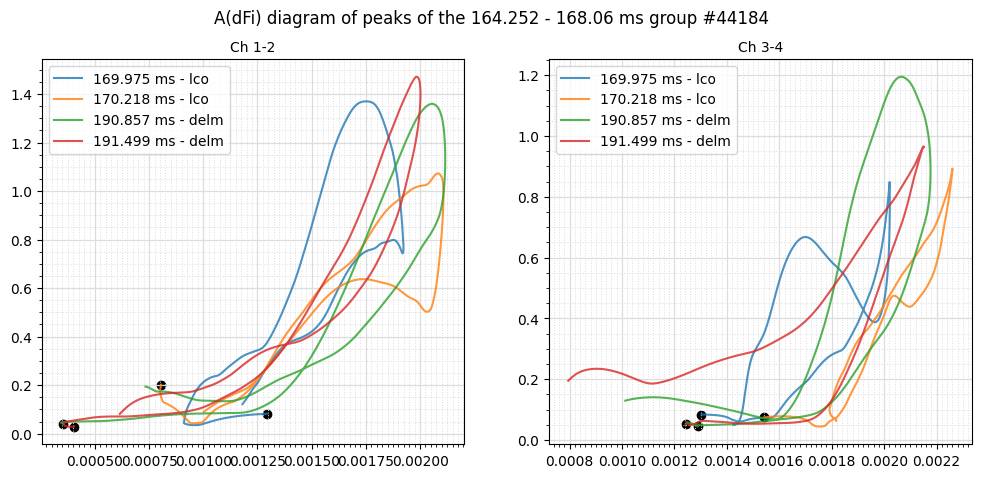

KeyboardInterrupt: Interrupted by user

In [36]:
time_points = points_df.timepoint.to_numpy()
marks = points_df.mark.to_numpy()

comm = input("Input point indexes:\n")
while len(comm) > 0:
    diagram_points_ind = list(map(int, comm.strip().split()))
    diagram_points = time_points[diagram_points_ind]

    fig, axs = plt.subplots(ncols=len(channels[::2]), gridspec_kw={'hspace': 0.2})  # , sharex=True
    fig.set_figwidth(12)
    fig.set_figheight(5)
    
    fig.suptitle(f"A(dFi) diagrams #{F_ID}")
    for ax_i, ch_i in enumerate(channels[::2]):
        axs[ax_i].set_title(f"Ch {ch_i}-{ch_i + 1}", fontsize="medium")
        for p_i in range(len(diagram_points)):
            time_mask = np.array((dbs_df.t * 1e6 >= diagram_points[p_i] - 100) & (dbs_df.t * 1e6 <= diagram_points[p_i] + 50))
            a = dbs_df[f"ch{ch_i}_A"][time_mask].to_numpy()
            dfi = dbs_df[f"ch{ch_i}_dfi"][time_mask].to_numpy()
            axs[ax_i].plot(a, dfi, label=f"{diagram_points[p_i]/1e3} ms - {marks[diagram_points_ind[p_i]]}", alpha=0.8)
            axs[ax_i].scatter(a[0], dfi[0], color="k")
        axs[ax_i].grid(which='major', color='#DDDDDD', linewidth=0.9)
        axs[ax_i].grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
        axs[ax_i].minorticks_on()
        axs[ax_i].xaxis.set_minor_locator(AutoMinorLocator(10))
        axs[ax_i].legend(loc='upper left')
    plt.show()
    comm = input("Input point indexes:\n")

---
---

In [ ]:
slices_df = pd.read_csv(proj_path + f"/data/df/marks/{F_ID}_marks.csv")
slices_edges = slices_df.to_numpy()[:, :2]
slices_marks = slices_df.to_numpy()[:, 2]

---
---